In [16]:
# Worm4専用 3面図(601x401/402)対応版：ギャップ内クロスライン＋元画像すぐ外の外枠（角落とし）＋最小パディング
import cv2
import numpy as np
from tqdm import tqdm

# === 入出力 ===
input_path  = "orthogonal_view_20240516-203245tdTomato-7mW-3_raw_gzip_bleachcorrect_top90_mean_full_adjustedG437M1643.avi"
output_path = "Worm4_orthogonal_view_20240516-203245tdTomato-7mW-3_raw_gzip_bleachcorrect_top90_mean_full_adjustedG437M1643_minpad.mp4"

# === レイアウト定数（不変） ===
XY_W  = 500
GAP   = 3
XZ_H_FIXED = 98      # このデータは xz=98px と明示あり
BORDER_THICKNESS = 2
COLOR = (255, 255, 255)

# === パディング（最小は枠の太さ）※側ごとに設定可能 ===
PAD_T = BORDER_THICKNESS
PAD_L = BORDER_THICKNESS
PAD_R = BORDER_THICKNESS
PAD_B = BORDER_THICKNESS

# === 角落とし設定（右下の“逆向きL字”を隠す） ===
# auto: 入力サイズから ZY 幅/XZ 高さを推定して使用、manual: 値を指定
CORNER_TRIM = {"mode": "auto", "x": 98, "y": 98}

# === 入力を開く ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps = cap.get(cv2.CAP_PROP_FPS)
W   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H   = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
N   = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"▶ {N} frames, {W}x{H}, {fps:.3f} fps")

# ---- 動的に XY_H / ZY_W / XZ_H を決定（このデータは XZ_H=98 前提）----
ZY_W = W - (XY_W + GAP)               # 例: 601-(500+3)=98
XY_H = H - (GAP + XZ_H_FIXED)         # 401→300 / 402→301
XZ_H = XZ_H_FIXED
if XY_H not in (300, 301):
    print(f"⚠️ 想定外のXY高さです: XY_H={XY_H} (H={H}). 処理は続行します。")

# === 出力を開く（最小パディングぶんだけ拡張） ===
out_w, out_h = W + PAD_L + PAD_R, H + PAD_T + PAD_B
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))
if not out.isOpened():
    raise RuntimeError("❌ 出力用動画ファイルを開けません")

def annotate_frame(src):
    """ギャップ内クロスライン + 元画像の“すぐ外側”のパディング上に外枠（角落とし対応）"""
    Hs, Ws = src.shape[:2]
    # パディング追加
    canvas = cv2.copyMakeBorder(src, PAD_T, PAD_B, PAD_L, PAD_R, cv2.BORDER_CONSTANT, value=(0,0,0))

    # ---- クロスライン（ギャップ帯のみ / 元画像端まで）----
    # 縦ギャップ: x = PAD_L + 500 .. +502, y = PAD_T .. PAD_T + Hs - 1
    x_v0 = PAD_L + XY_W
    x_v1 = x_v0 + GAP - 1
    cv2.rectangle(canvas, (x_v0, PAD_T), (x_v1, PAD_T + Hs - 1), COLOR, -1)

    # 横ギャップ: y = PAD_T + XY_H .. +XY_H+2, x = PAD_L .. PAD_L + Ws - 1
    y_h0 = PAD_T + XY_H
    y_h1 = y_h0 + GAP - 1
    cv2.rectangle(canvas, (PAD_L, y_h0), (PAD_L + Ws - 1, y_h1), COLOR, -1)

    # ---- 角落とし量（右下の逆向きL字を隠す）----
    if CORNER_TRIM["mode"] == "auto":
        trim_x = int(ZY_W)       # 下枠を右端から短く（ZY幅ぶん）
        trim_y = int(XZ_H)       # 右枠を下端から短く（XZ高ぶん）
    else:
        trim_x = max(0, int(CORNER_TRIM.get("x", 0)))
        trim_y = max(0, int(CORNER_TRIM.get("y", 0)))
    trim_x = min(trim_x, Ws - 1)
    trim_y = min(trim_y, Hs - 1)

    t = BORDER_THICKNESS

    # ---- 外枠（元画像の“すぐ外側”のパディング上のみ）----
    # 上
    y0, y1 = max(0, PAD_T - t), PAD_T - 1
    if y1 >= y0:
        cv2.rectangle(canvas, (PAD_L, y0), (PAD_L + Ws - 1, y1), COLOR, -1)
    # 左
    x0, x1 = max(0, PAD_L - t), PAD_L - 1
    if x1 >= x0:
        cv2.rectangle(canvas, (x0, PAD_T), (x1, PAD_T + Hs - 1), COLOR, -1)
    # 右（下端から trim_y 分短く）
    x0, x1 = PAD_L + Ws, min(canvas.shape[1] - 1, PAD_L + Ws + t - 1)
    y0, y1 = PAD_T, PAD_T + Hs - 1 - trim_y
    if x1 >= x0 and y1 >= y0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)
    # 下（右端から trim_x 分短く）
    y0, y1 = PAD_T + Hs, min(canvas.shape[0] - 1, PAD_T + Hs + t - 1)
    x0, x1 = PAD_L, PAD_L + Ws - 1 - trim_x
    if y1 >= y0 and x1 >= x0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)

    return canvas

# === 各フレーム処理 ===
for _ in tqdm(range(N), desc="書き出し中"):
    ret, frame = cap.read()
    if not ret:
        break
    out.write(annotate_frame(frame))

cap.release()
out.release()
print(f"✅ 完了: {output_path}  (size: {out_w}x{out_h}, XY_H={XY_H}, ZY_W={ZY_W}, XZ_H={XZ_H})")


▶ 9995 frames, 601x402, 50.000 fps


書き出し中: 100%|██████████████████████████| 9995/9995 [00:29<00:00, 337.38it/s]

✅ 完了: Worm4_orthogonal_view_20240516-203245tdTomato-7mW-3_raw_gzip_bleachcorrect_top90_mean_full_adjustedG437M1643_minpad.mp4  (size: 605x406, XY_H=301, ZY_W=98, XZ_H=98)


In [15]:
# WWorm1~3専用, 3面図(601x401)専用：ギャップ内クロスライン＋パディング外枠で動画書き出し, 外側パディングは縮小
import cv2
import numpy as np
from tqdm import tqdm

# === 入出力 ===
input_path  = "1_bleachcorrected_full_top90_mean_full_adjustedG297M1484.avi"
output_path = "Worm1_1_bleachcorrected_full_top90_mean_full_adjustedG297M1484_minpad.mp4"

# === レイアウト定数（固定） ===
XY_W, XY_H = 500, 300
GAP        = 3                # xy-xz / xy-zy のギャップ
W_EXPECT   = 601              # 500 + 3 + 98
H_EXPECT   = 401              # 300 + 3 + 98

# === 描画スタイル ===
BORDER_THICKNESS = 2
COLOR = (255, 255, 255)

# === パディング（最小は枠の太さ）※側ごとに設定可能 ===
PAD_T = BORDER_THICKNESS
PAD_L = BORDER_THICKNESS
PAD_R = BORDER_THICKNESS
PAD_B = BORDER_THICKNESS
# ラベル等を後で入れるなら、必要な側だけ足してください（例: PAD_B += 20 など）

# === 角落とし設定（右下の“逆向きL字”を隠す） ===
# auto: 動画サイズから ZY 幅/XZ 高さを推定して使用、manual: 値を指定
CORNER_TRIM = {"mode": "auto", "x": 98, "y": 98}

# === 入力を開く ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps     = cap.get(cv2.CAP_PROP_FPS)
W       = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H       = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
N       = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"▶ {N} frames, {W}x{H}, {fps:.3f} fps")
if (W, H) != (W_EXPECT, H_EXPECT):
    print(f"⚠️ 入力サイズが想定(601x401)と異なります: {W}x{H}（座標は 500/300/3 基準で処理）")

# === 出力を開く（最小パディングを反映） ===
out_w, out_h = W + PAD_L + PAD_R, H + PAD_T + PAD_B
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))
if not out.isOpened():
    raise RuntimeError("❌ 出力用動画ファイルを開けません")

def annotate_frame(src):
    """ギャップ内クロスライン + 元画像の“すぐ外側”のパディング上に外枠（角落とし対応）"""
    Hs, Ws = src.shape[:2]

    # パディング追加
    canvas = cv2.copyMakeBorder(
        src, PAD_T, PAD_B, PAD_L, PAD_R, cv2.BORDER_CONSTANT, value=(0,0,0)
    )

    # ---- クロスライン（ギャップ帯のみ / 元画像端まで）----
    # 縦ギャップ: x = PAD_L + 500 .. +502, y = PAD_T .. PAD_T + Hs - 1
    x_v0 = PAD_L + XY_W
    x_v1 = x_v0 + GAP - 1
    cv2.rectangle(canvas, (x_v0, PAD_T), (x_v1, PAD_T + Hs - 1), COLOR, -1)

    # 横ギャップ: y = PAD_T + 300 .. +302, x = PAD_L .. PAD_L + Ws - 1
    y_h0 = PAD_T + XY_H
    y_h1 = y_h0 + GAP - 1
    cv2.rectangle(canvas, (PAD_L, y_h0), (PAD_L + Ws - 1, y_h1), COLOR, -1)

    # ---- 角落とし量を決定 ----
    if CORNER_TRIM["mode"] == "auto":
        zy_w = Ws - (XY_W + GAP)        # = 98 想定
        xz_h = Hs - (XY_H + GAP)        # = 98 想定
        trim_x = int(zy_w)              # 下枠を右端から短く
        trim_y = int(xz_h)              # 右枠を下端から短く
    else:
        trim_x = max(0, int(CORNER_TRIM.get("x", 0)))
        trim_y = max(0, int(CORNER_TRIM.get("y", 0)))

    trim_x = min(trim_x, Ws - 1)
    trim_y = min(trim_y, Hs - 1)
    t = BORDER_THICKNESS

    # ---- 外枠（元画像の“すぐ外側”のパディング上のみ）----
    # 上
    y0, y1 = max(0, PAD_T - t), PAD_T - 1
    if y1 >= y0:
        cv2.rectangle(canvas, (PAD_L, y0), (PAD_L + Ws - 1, y1), COLOR, -1)
    # 左
    x0, x1 = max(0, PAD_L - t), PAD_L - 1
    if x1 >= x0:
        cv2.rectangle(canvas, (x0, PAD_T), (x1, PAD_T + Hs - 1), COLOR, -1)
    # 右（下端から trim_y 分短く）
    x0, x1 = PAD_L + Ws, min(canvas.shape[1] - 1, PAD_L + Ws + t - 1)
    y0, y1 = PAD_T, PAD_T + Hs - 1 - trim_y
    if x1 >= x0 and y1 >= y0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)
    # 下（右端から trim_x 分短く）
    y0, y1 = PAD_T + Hs, min(canvas.shape[0] - 1, PAD_T + Hs + t - 1)
    x0, x1 = PAD_L, PAD_L + Ws - 1 - trim_x
    if y1 >= y0 and x1 >= x0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)

    return canvas

# === 各フレーム処理 ===
for _ in tqdm(range(N), desc="書き出し中"):
    ret, frame = cap.read()
    if not ret:
        break
    out.write(annotate_frame(frame))

cap.release()
out.release()
print(f"✅ 完了: {output_path}  (size: {out_w}x{out_h})")


▶ 9995 frames, 601x401, 50.000 fps


書き出し中: 100%|██████████████████████████| 9995/9995 [00:41<00:00, 243.29it/s]

✅ 完了: Worm1_1_bleachcorrected_full_top90_mean_full_adjustedG297M1484_minpad.mp4  (size: 605x405)


In [12]:
# 3面図(601x401)専用：ギャップ内クロスライン＋パディング外枠で動画書き出し
import cv2
import numpy as np
from tqdm import tqdm

# === 入出力 ===
input_path  = "orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.avi"
output_path = "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4"

# === レイアウト定数（固定） ===
XY_W, XY_H = 500, 300
GAP        = 3
ZY_W       = 98
XZ_H       = 98
# 想定サイズ（=601x401）
W_EXPECT = XY_W + GAP + ZY_W
H_EXPECT = XY_H + GAP + XZ_H

# === 描画スタイル ===
PAD = 40                          # 外枠を載せるためのパディング
BORDER_THICKNESS = 2
COLOR = (255, 255, 255)

# === 入力を開く ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

fps     = cap.get(cv2.CAP_PROP_FPS)
width   = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height  = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
nframes = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
print(f"▶ {nframes} frames, {width}x{height}, {fps:.3f} fps")

# サイズ確認（想定と違っても処理は続行。座標は 500/300/3 を基準に計算）
if (width, height) != (W_EXPECT, H_EXPECT):
    print(f"⚠️ 入力サイズが想定(601x401)と異なります: {width}x{height}  ただし座標は想定通りで描画します。")

# === 出力を開く（パディング分だけ大きいキャンバス） ===
out_w, out_h = width + 2*PAD, height + 2*PAD
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (out_w, out_h))
if not out.isOpened():
    raise RuntimeError("❌ 出力用動画ファイルを開けません")

# === 角落とし設定 ===
# mode="auto": 三面図の寸法から自動で trim を決める（推奨）
# mode="manual": 下の x,y を使う（例: x=90, y=88 など）
CORNER_TRIM = {"mode": "auto", "x": 98, "y": 98}

# 既存の annotate_frame をこの版に置き換え
def annotate_frame(src):
    """
    - クロスライン：ギャップ帯（x=500..502 / y=300..302）のみ塗りつぶし、
                      かつ元画像の端(PAD境界の内側)まで到達させる
    - 外枠：元画像の“すぐ外側”（パディング上）にのみ描画
    - 右下角：右枠を下端から trim_y 分短く、下枠を右端から trim_x 分短くして
              逆向きL字が見えないようにする
    """
    H, W = src.shape[:2]

    # レイアウト定数（固定）
    XY_W, XY_H, GAP = 500, 300, 3
    ZY_W  = W - (XY_W + GAP)     # = 98 を想定
    XZ_H  = H - (XY_H + GAP)     # = 98 を想定

    # キャンバス（パディング追加）
    canvas = cv2.copyMakeBorder(src, PAD, PAD, PAD, PAD,
                                cv2.BORDER_CONSTANT, value=(0,0,0))

    # ---- クロスライン（ギャップ帯だけ、元画像端まで）----
    # 縦ギャップ x=500..502 を y=0..H-1 に
    x_v0 = PAD + XY_W
    x_v1 = x_v0 + GAP - 1
    cv2.rectangle(canvas, (x_v0, PAD), (x_v1, PAD + H - 1), COLOR, -1)

    # 横ギャップ y=300..302 を x=0..W-1 に
    y_h0 = PAD + XY_H
    y_h1 = y_h0 + GAP - 1
    cv2.rectangle(canvas, (PAD, y_h0), (PAD + W - 1, y_h1), COLOR, -1)

    # ---- 角落とし量を決定 ----
    if CORNER_TRIM["mode"] == "auto":
        trim_x = int(ZY_W)   # 下枠を右端から短く
        trim_y = int(XZ_H)   # 右枠を下端から短く
    else:
        trim_x = max(0, int(CORNER_TRIM.get("x", 0)))
        trim_y = max(0, int(CORNER_TRIM.get("y", 0)))

    # 安全クランプ
    trim_x = min(trim_x, W - 1)
    trim_y = min(trim_y, H - 1)

    t = int(BORDER_THICKNESS)

    # ---- 外枠（元画像の“すぐ外側”にのみ）----
    # 上
    y0, y1 = max(0, PAD - t), PAD - 1
    if y1 >= y0:
        cv2.rectangle(canvas, (PAD, y0), (PAD + W - 1, y1), COLOR, -1)
    # 左
    x0, x1 = max(0, PAD - t), PAD - 1
    if x1 >= x0:
        cv2.rectangle(canvas, (x0, PAD), (x1, PAD + H - 1), COLOR, -1)
    # 右（下端から trim_y 分 短く）
    x0, x1 = PAD + W, min(canvas.shape[1] - 1, PAD + W + t - 1)
    y0, y1 = PAD, PAD + H - 1 - trim_y
    if x1 >= x0 and y1 >= y0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)
    # 下（右端から trim_x 分 短く）
    y0, y1 = PAD + H, min(canvas.shape[0] - 1, PAD + H + t - 1)
    x0, x1 = PAD, PAD + W - 1 - trim_x
    if y1 >= y0 and x1 >= x0:
        cv2.rectangle(canvas, (x0, y0), (x1, y1), COLOR, -1)

    return canvas

# === 各フレーム処理 ===
for _ in tqdm(range(nframes), desc="書き出し中"):
    ret, frame = cap.read()
    if not ret:
        break
    out.write(annotate_frame(frame))

# === 後処理 ===
cap.release()
out.release()
print(f"✅ 完了: {output_path}")


▶ 9995 frames, 601x401, 50.000 fps


書き出し中: 100%|██████████████████████████| 9995/9995 [00:32<00:00, 307.97it/s]

✅ 完了: Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4


In [9]:
#NG#修正版　最終版 Worm Xのオリジナル三面図動画に対して、境界線、フレーム、スケールバー（任意）を挿れるコード
#画像内に境界線やフレームが重ならないように修正

import cv2
import numpy as np
from tqdm import tqdm

# === 入出力ファイル ===
input_path = "orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.avi"
output_path = "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4"

# === 入力動画を開く ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

# === 動画情報取得 ===
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"▶ 処理開始: {n_frames} フレーム, 解像度 {width}×{height}, {fps:.2f} fps")

# === 出力動画の設定 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise RuntimeError("❌ 出力用動画ファイルを開けません")

def draw_all_annotations(frame, color=(255, 255, 255), border_thickness=2):
    """
    3面図(601x401)に対して：
      - 境界線：XY-zy 縦ギャップ(x=500..502, y=0..299) と XY-xz 横ギャップ(x=0..499, y=300..302) のみ塗りつぶし
      - 外枠：面が存在しない「空白域」にのみ描く
          * 右枠：x=600 側の縦帯（y=303..400）
          * 下枠：y=400 側の横帯（x=503..600）
      いずれも中身（xy/xz/zy）には食い込まない
    """
    h, w = frame.shape[:2]
    assert w == 601 and h == 401, "想定サイズと異なります（601x401 を想定）"

    # レイアウト定数
    xy_w, xy_h = 500, 300
    gap = 3

    # ---- 境界線（ギャップ帯の中だけ）----
    # 縦ギャップ：x=500..502, y=0..299
    x_v0, x_v1 = xy_w, xy_w + gap - 1          # 500..502
    y_v0, y_v1 = 0, xy_h - 1                   # 0..299
    cv2.rectangle(frame, (x_v0, y_v0), (x_v1, y_v1), color, -1)

    # 横ギャップ：x=0..499, y=300..302
    x_h0, x_h1 = 0, xy_w - 1                   # 0..499
    y_h0, y_h1 = xy_h, xy_h + gap - 1          # 300..302
    cv2.rectangle(frame, (x_h0, y_h0), (x_h1, y_h1), color, -1)

    # ---- 外枠（空白域のみ。面に食い込ませない）----
    t = int(border_thickness)

    # 右枠：右端の縦帯（x=601-t..600）を、空白域 y=303..400 のみに描画
    #  ※y=0..299 は zy 面があるので描かない。y=300..302 は横ギャップなので避ける。
    x_r0, x_r1 = w - t, w - 1                  # 601-t .. 600
    y_r0, y_r1 = xy_h + gap + 0, h - 1         # 303 .. 400
    if x_r0 <= x_r1 and y_r0 <= y_r1:
        cv2.rectangle(frame, (x_r0, y_r0), (x_r1, y_r1), color, -1)

    # 下枠：下端の横帯（y=401-t..400）を、空白域 x=503..600 のみに描画
    #  ※x=0..499 は xz 面、x=500..502 は縦ギャップなので避ける。
    y_b0, y_b1 = h - t, h - 1                  # 401-t .. 400
    x_b0, x_b1 = xy_w + gap + 0, w - 1         # 503 .. 600
    if y_b0 <= y_b1 and x_b0 <= x_b1:
        cv2.rectangle(frame, (x_b0, y_b0), (x_b1, y_b1), color, -1)

    return frame


# === 各フレーム処理 ===
for _ in tqdm(range(n_frames), desc="書き出し中"):
    ret, frame = cap.read()
    if not ret:
        break

    annotated = draw_all_annotations(frame)
    out.write(annotated)

# === 後処理 ===
cap.release()
out.release()
print(f"✅ 完了: {output_path} が保存されました")


▶ 処理開始: 9995 フレーム, 解像度 601×401, 50.00 fps


書き出し中: 100%|██████████████████████████| 9995/9995 [00:34<00:00, 289.09it/s]


✅ 完了: Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4 が保存されました


In [8]:
#NG #最終版 Worm Xのオリジナル三面図動画に対して、境界線、フレーム、スケールバー（任意）を挿れるコード

import cv2
import numpy as np
from tqdm import tqdm

# === 入出力ファイル ===
input_path = "orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.avi"
output_path = "Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4"

# === 入力動画を開く ===
cap = cv2.VideoCapture(input_path)
if not cap.isOpened():
    raise RuntimeError("❌ 入力動画が開けません")

# === 動画情報取得 ===
fps = cap.get(cv2.CAP_PROP_FPS)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f"▶ 処理開始: {n_frames} フレーム, 解像度 {width}×{height}, {fps:.2f} fps")

# === 出力動画の設定 ===
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
if not out.isOpened():
    raise RuntimeError("❌ 出力用動画ファイルを開けません")

# === アノテーション関数（更新版） ===
def draw_all_annotations(frame, px_per_um=0.4095, bar_um=20, bar_thickness=2, color=(255, 255, 255)):
    t = 2
    w_in = width - 2
    h_in = height - 2

    # 枠線（中央・外周）一部省略あり
    lines = [
        ((0, 0), (w_in, 0)),             # 上辺
        ((0, 0), (0, h_in)),             # 左辺
        ((w_in, 0), (w_in, 302)),        # 右上縦線
        ((0, h_in), (503, h_in)),        # 下辺左
        ((503, 0), (503, h_in)),         # 全高中央縦線
    ]
    for pt1, pt2 in lines:
        cv2.line(frame, pt1, pt2, color, t)

    # 境界線（塗りつぶし）
    cv2.rectangle(frame, (0, 301), (600, 303), color, -1)   # xy–xz（水平）
    cv2.rectangle(frame, (501, 0), (503, 400), color, -1)   # xy–yz（垂直）

    # スケールバー（右下 xy面）->動画統合時に50 umのスケールバーを入れるのでここはスキップ
#    bar_px = int(round(bar_um / px_per_um))  # 20 µm → 約49 px
#    x_end = 503 - 10
#    y_end = 301 - 10
#    x_start = x_end - bar_px
#    y_start = y_end - bar_thickness + 1
#    cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), color, -1)

    return frame

# === 各フレーム処理 ===
for _ in tqdm(range(n_frames), desc="書き出し中"):
    ret, frame = cap.read()
    if not ret:
        break

    annotated = draw_all_annotations(frame)
    out.write(annotated)

# === 後処理 ===
cap.release()
out.release()
print(f"✅ 完了: {output_path} が保存されました")


▶ 処理開始: 9995 フレーム, 解像度 601×401, 50.00 fps


書き出し中: 100%|███████████████████████████| 9995/9995 [01:41<00:00, 98.40it/s]


✅ 完了: Worm3_orthogonal_view_20240508-200229tdTomato-10mW-4_raw_gzip_bleachcorrect_top90_mean_full_adjustedG495M2544.mp4 が保存されました


✅ 画像を書き出しました: preview_frame_with_all_annotations.png


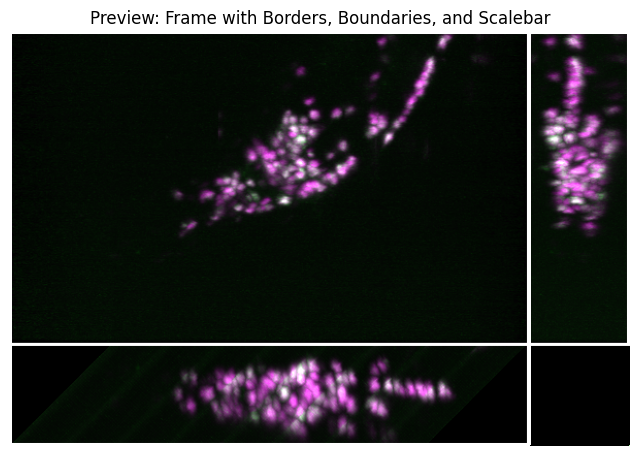

In [1]:
#Image確認用　Worm Xのオリジナル三面図動画の1枚目の画像に対して、境界線、フレーム、スケールバー（任意）を挿れるコード

import cv2
import numpy as np
import matplotlib.pyplot as plt

# === 入力ファイル ===
input_path = "1_bleachcorrected_full_top90_mean_full_adjustedG297M1484.avi"
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("❌ 最初のフレームの読み込みに失敗しました")

# === フレームサイズ取得 ===
height, width = frame.shape[:2]

# === 線描画関数 ===
def draw_all_annotations(frame, px_per_um=0.4095, bar_um=20, bar_thickness=2, color=(255, 255, 255)):
    t = 2  # 線の太さ
    w_in = width - 2
    h_in = height - 2

    # --- 枠線 ---
    lines = [
        ((0, 0), (w_in, 0)),             # 上辺
        ((0, 0), (0, h_in)),             # 左辺
        ((w_in, 0), (w_in, 302)),        # 右上縦線
        ((0, h_in), (503, h_in)),        # 下辺左
       # ((503, 308), (503, h_in)),       # 中央縦
       # ((503, 308), (w_in, 308)),       # 中央横（右側）
        ((503, 0), (503, h_in)),         # 全高中央縦線
       # ((0, 308), (w_in, 308)),         # 全幅中央横線
    ]
    for pt1, pt2 in lines:
        cv2.line(frame, pt1, pt2, color, t)

    # --- 境界線（塗りつぶし）---
    cv2.rectangle(frame, (0, 301), (600, 303), color, -1)   # xy–xz（水平）
    cv2.rectangle(frame, (501, 0), (503, 400), color, -1)   # xy–yz（垂直）

    # --- スケールバー（xy領域右下）---
  #  bar_px = int(round(bar_um / px_per_um))  # e.g., 20 µm ÷ 0.4095 µm/px ≈ 49 px
   # x_end = 503 - 10
   # y_end = 301 - 10
   # x_start = x_end - bar_px
   # y_start = y_end - bar_thickness + 1
   # cv2.rectangle(frame, (x_start, y_start), (x_end, y_end), color, -1)

    return frame

# === 描画の実行 ===
annotated_frame = draw_all_annotations(frame.copy())

# === 保存と表示 ===
cv2.imwrite("preview_frame_with_all_annotations.png", annotated_frame)
print("✅ 画像を書き出しました: preview_frame_with_all_annotations.png")

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.title("Preview: Frame with Borders, Boundaries, and Scalebar")
plt.axis("off")
plt.show()


✅ 境界線＋スケールバー付き画像を保存しました: orthogonal_view_boundaries_with_scalebar.png


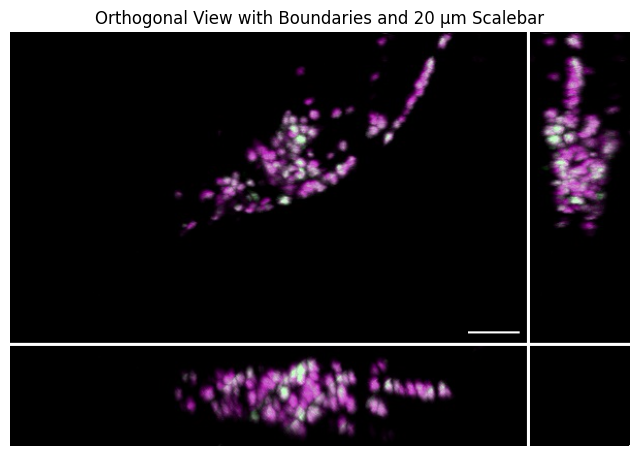

In [4]:
#テスト用

import cv2
import numpy as np
import matplotlib.pyplot as plt

# === 入力画像の読み込み ===
input_path = "orthogonal_view_highres.avi"
cap = cv2.VideoCapture(input_path)
ret, frame = cap.read()
cap.release()

if not ret:
    raise RuntimeError("❌ フレームの読み込みに失敗しました")

# === 描画関数 ===
def draw_boundaries_and_scalebar(img,
                                  px_per_um=0.4095,
                                  bar_um=20,
                                  bar_thickness=2,
                                  color=(255, 255, 255)):

    h, w = img.shape[:2]
    assert (w, h) == (601, 401), f"画像サイズは601×401である必要があります（現在: {w}×{h})"

    # --- 境界線 ---
    img = cv2.rectangle(img, (0, 301), (600, 303), color, -1)   # xy–xz 水平
    img = cv2.rectangle(img, (501, 0), (503, 400), color, -1)   # xy–yz 垂直

    # --- スケールバー ---
    bar_px = int(round(bar_um / px_per_um))  # 20 µm → 49 px

    # xy–xzとxy–yzの交差点：(503, 301)
    # そこから x+3, y+3 ずらした位置にバーの右下端
    x_end = 503 - 10
    y_end = 301 - 10
    x_start = x_end - bar_px
    y_start = y_end - bar_thickness + 1  # 上から描く

    img = cv2.rectangle(img, (x_start, y_start), (x_end, y_end), color, -1)

    return img

# === 境界線とスケールバーを描画 ===
framed = draw_boundaries_and_scalebar(frame.copy())

# === 出力保存・表示 ===
output_path = "orthogonal_view_boundaries_with_scalebar.png"
cv2.imwrite(output_path, framed)
print(f"✅ 境界線＋スケールバー付き画像を保存しました: {output_path}")

plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(framed, cv2.COLOR_BGR2RGB))
plt.title("Orthogonal View with Boundaries and 20 µm Scalebar")
plt.axis("off")
plt.show()
